In [13]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import glob

In [164]:
# Chemin vers les fichiers CSV
chemin = '/content/players/*.csv'

# Liste des noms de fichiers
fichiers = glob.glob(chemin)

# Initialisation d'une liste pour stocker les DataFrames de chaque fichier
dfs = []
# Liste des encodages à essayer
encodings_to_try = [ 'utf-8','ISO-8859-1']

# Charger et concaténer les fichiers
for fichier in fichiers:
    df = None
    # Essayer différents encodages jusqu'à ce que la lecture réussisse
    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(fichier, encoding=encoding)
            print(f"Lecture réussie avec l'encodage {encoding}.")
            break  # Sortir de la boucle si la lecture réussit avec un encodage
        except UnicodeDecodeError:
            print(f"Échec de la lecture avec l'encodage {encoding}. Essayer un autre encodage.")

    if df is not None:
        # Ajouter une colonne 'source' pour identifier la provenance de chaque fichier
        nom_fichier = fichier.split('/')[-1]
        saison = nom_fichier.split('.')[0].split('-')
        df['source'] = f"{saison[0]}-{saison[1]}"
        # Concaténer 'first_name' et 'second_name' en une seule colonne 'name'
        df['name'] = df['first_name'] + ' ' + df['second_name']
        # Supprimer les colonnes 'first_name' et 'second_name'
        df = df.drop(columns=['first_name', 'second_name'])
        # Ajouter le DataFrame à la liste
        dfs.append(df)
    else:
        print("Échec de la lecture du fichier:", fichier)


# Concaténer tous les DataFrames en un seul
data = pd.concat(dfs, ignore_index=True)



# Maintenant vous pouvez faire du traitement de données sur le DataFrame 'data'
# Par exemple, afficher les premières lignes
print(data.head())


Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Échec de la lecture avec l'encodage utf-8. Essayer un autre encodage.
Lecture réussie avec l'encodage ISO-8859-1.
   goals_scored  assists  total_points  minutes  goals_conceded  creativity  \
0             0        0             0        0               0         0.0   
1             0        0             0        0               0         0.0   
2             0        1             4        1               0         0.5   
3             1        3            21      236               2        63.6   
4             0        0            40     1104              12        56.7   

   influence  threat  bonus  bps  ict_index  clean_sheets  red_cards  \
0        0.0     0.0      0    0        0.0             0         

In [186]:
# Ingénierie des caractéristiques
selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']
X = data[selected_features]
y = data['total_points']

In [187]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = X_train.select_dtypes(include=['number']).columns

In [189]:
# Vérification des valeurs manquantes dans les données d'entraînement
print("Valeurs manquantes dans y_train:", np.isnan(y_train).sum())

# Vérification des valeurs manquantes dans les données de test
print("Valeurs manquantes dans y_test:", np.isnan(y_test).sum())


Valeurs manquantes dans y_train: 0
Valeurs manquantes dans y_test: 0


In [190]:
# Définir les hyperparamètres à optimiser
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'l2_regularization': [0.0, 0.1, 0.2]
}


In [65]:
# Create the HistGradientBoostingRegressor model
model = HistGradientBoostingRegressor()

In [66]:
# Train the model
model.fit(X_train, y_train)


HistGradientBoostingRegressor()

In [67]:
# Predict on the test set
y_pred = model.predict(X_test)

In [11]:
# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


Evaluation des performances du modèle

In [14]:
# Effectuer la validation croisée
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')


In [15]:
# Exécuter la recherche par grille sur les données
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(), n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 300],
                         'min_samples_leaf': [1, 2, 4]},
             scoring='neg_mean_squared_error')

In [68]:
# Calcul des métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# Calculer la moyenne des scores de MSE
avg_mse = -scores.mean()

In [69]:
# Afficher les meilleurs paramètres et la meilleure MSE
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure MSE:", -grid_search.best_score_)

Meilleurs paramètres: {'l2_regularization': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 300, 'min_samples_leaf': 1}
Meilleure MSE: 33.61651634316287


In [70]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)

# Afficher le score moyen de MSE
print("Moyenne des scores de MSE:", avg_mse)

Mean Squared Error: 37.39831031513151
R-squared: 0.9843335717720226
Mean Absolute Error: 3.7683396209859032
Moyenne des scores de MSE: 35.83683566762546


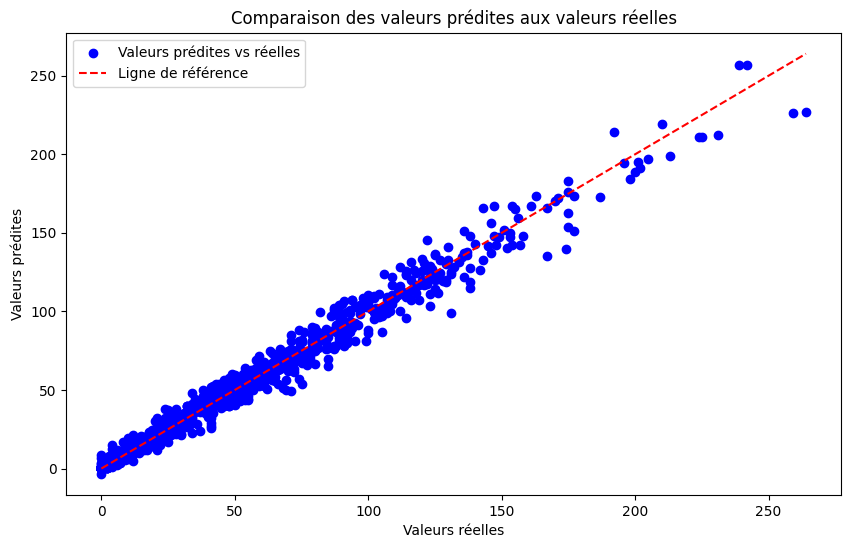

In [71]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

In [191]:
# Créer un nouveau modèle avec les paramètres optimisés
optimal_model = HistGradientBoostingRegressor(
    l2_regularization=0.0,
    learning_rate=0.1,
    max_depth=5,
    max_iter=300,
    min_samples_leaf=2
)


In [192]:
# Entraîner le nouveau modèle avec les données d'entraînement
optimal_model.fit(X_train, y_train)

HistGradientBoostingRegressor(max_depth=5, max_iter=300, min_samples_leaf=2)

In [193]:
# Prédire sur les données de test
y_pred_optimal = optimal_model.predict(X_test)

In [194]:
# Évaluer les performances du nouveau modèle sur les données de test
mse_optimal = mean_squared_error(y_test, y_pred_optimal)
r2_optimal = r2_score(y_test, y_pred_optimal)
mae_optimal = mean_absolute_error(y_test, y_pred_optimal)

In [195]:
# Afficher les performances du nouveau modèle
print("Performances du modèle avec les paramètres optimisés :")
print("MSE:", mse_optimal)
print("R-squared:", r2_optimal)
print("MAE:", mae_optimal)

Performances du modèle avec les paramètres optimisés :
MSE: 40.32655493266768
R-squared: 0.98310690848836
MAE: 3.808415065634732


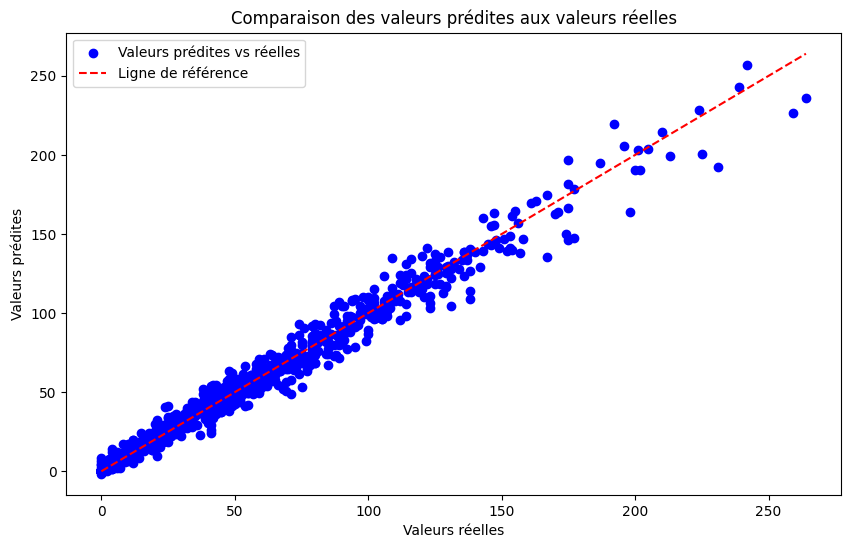

In [196]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimal, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

In [198]:
print(data.tail())

      goals_scored  assists  total_points  minutes  goals_conceded  \
5601             0        0             0        0               0   
5602             0        0             1        3               0   
5603             0        0             0        0               0   
5604             0        0             0        0               0   
5605             0        0             0        0               0   

      creativity  influence  threat  bonus  bps  ict_index  clean_sheets  \
5601         0.0        0.0     0.0      0    0        0.0             0   
5602         3.8        0.8     0.0      0    2        0.5             0   
5603         0.0        0.0     0.0      0    0        0.0             0   
5604         0.0        0.0     0.0      0    0        0.0             0   
5605         0.0        0.0     0.0      0    0        0.0             0   

      red_cards  yellow_cards  selected_by_percent  now_cost element_type  \
5601          0             0                

In [199]:
def predict_player_performance(model, player_name, data):
    # Filtrer les données pour obtenir les caractéristiques du joueur spécifié
    player_data = data[data['name'] == player_name]

    # Sélectionner uniquement les caractéristiques utilisées lors de l'entraînement
    selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']


    player_data = player_data[selected_features]

    # Effectuer la prédiction
    predicted_performance = optimal_model.predict(player_data)

    # Calculer la moyenne des performances prédites
    average_performance = np.mean(predicted_performance)

    return average_performance

In [214]:
# Nom du joueur à prédire
player_name = 'Erling Haaland'

# Prédiction des performances du joueur
predicted_performance = predict_player_performance(optimal_model, player_name, team_data)

print("Performances prédites (total_points) pour le joueur: ",player_name, predicted_performance)


Performances prédites (total_points) pour le joueur:  Erling Haaland 4.990455629675643


In [201]:
# Sélectionner les informations pour le joueur spécifié
player_info = data[data['name'] == player_name]

# Vérifier si le joueur spécifié est présent dans les données
if not player_info.empty:
    # Extraire les informations nécessaires
    now_cost = player_info['now_cost'].values[0]
    total_points = player_info['total_points'].values[0]
    position = player_info['element_type'].values[0]  # Assurez-vous que 'element_type' contient les informations sur le poste du joueur

    # Afficher les informations
    print("Nom du joueur:", player_name)
    print("Prix actuel:", now_cost)
    print("Total de points actuel:", total_points)
    print("Poste:", position)
else:
    print("Le joueur spécifié n'a pas été trouvé dans les données.")


Nom du joueur: Erling Haaland
Prix actuel: 140.0
Total de points actuel: 112
Poste: FWD


prediction pour les joeurus de la saison en cours

In [202]:
team_data = pd.read_csv('/content/gw27.csv')
team_data = team_data.rename(columns={'value': 'now_cost'})

print(team_data.head())
print(len(team_data))

               name position           team   xP  assists  bonus  bps  \
0       Femi Seriki      DEF  Sheffield Utd  0.0        0      0    0   
1     Josh Brooking      DEF        Chelsea  0.0        0      0    0   
2       Radek Vítek       GK        Man Utd  0.0        0      0    0   
3  Jack Hinshelwood      MID       Brighton  0.0        0      0    0   
4      Jadon Sancho      MID        Man Utd  0.0        0      0    0   

   clean_sheets  creativity  element  ...  team_a_score  team_h_score  threat  \
0             0         0.0      653  ...             6             0     0.0   
1             0         0.0      723  ...             2             2     0.0   
2             0         0.0      669  ...             1             3     0.0   
3             0         0.0      621  ...             0             3     0.0   
4             0         0.0      397  ...             1             3     0.0   

   total_points  transfers_balance  transfers_in  transfers_out  now_cost 

In [204]:

# Créer une liste pour stocker les prédictions de performances pour tous les joueurs de la saison 23-24
all_predictions = []

# Itérer sur chaque joueur dans le DataFrame de la saison 23-24
for player_name in team_data['name']:
    # Prédiction des performances du joueur avec le modèle entraîné
    predicted_performance = predict_player_performance(optimal_model, player_name, team_data)

    # Ajouter le nom du joueur et ses prédictions à la liste
    all_predictions.append((player_name, predicted_performance))

# Afficher les prédictions pour tous les joueurs de la saison 23-24
for player_name, predicted_performance in all_predictions:
    print("Performances prédites (total_points) pour le joueur:", player_name, ":", predicted_performance)


Performances prédites (total_points) pour le joueur: Femi Seriki : 0.008913491896805082
Performances prédites (total_points) pour le joueur: Josh Brooking : 0.008913491896805082
Performances prédites (total_points) pour le joueur: Radek Vítek : 0.008913491896805082
Performances prédites (total_points) pour le joueur: Jack Hinshelwood : 0.10754178274003064
Performances prédites (total_points) pour le joueur: Jadon Sancho : -0.11846580224248894
Performances prédites (total_points) pour le joueur: Divock Origi : 5.240079697041862
Performances prédites (total_points) pour le joueur: Sam Curtis : 0.008913491896805082
Performances prédites (total_points) pour le joueur: Rhys Norrington-Davies : 0.008913491896805082
Performances prédites (total_points) pour le joueur: Vitaly Janelt : 2.807197133774309
Performances prédites (total_points) pour le joueur: Ionuț Radu : 0.062391761384509754
Performances prédites (total_points) pour le joueur: Andre Brooks : 1.4833789815486196
Performances prédite

In [205]:
print(len(all_predictions))

832


In [206]:
# Créer un dictionnaire à partir de la liste de toutes les prédictions
predicted_performances_dict = {player_name: predicted_performance for player_name, predicted_performance in all_predictions}


Création d'une equipe

In [209]:
def create_team(predicted_performances, data, budget=100, max_players_per_team=3):
    team = []
    remaining_budget = budget
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}

    # Tri des joueurs prédits par performances décroissantes en fonction de la performance divisée par le coût
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1] / data[data['name'] == x[0]]['now_cost'].values[0], reverse=True)

    # Sélection des joueurs pour l'équipe en respectant les contraintes
    for player_name, predicted_performance in sorted_players:
        # Vérifier si l'équipe a déjà atteint le nombre maximum de joueurs
        if len(team) >= 15:
            break

        # Vérifier si le joueur est présent dans les données
        player_data = data[data['name'] == player_name]
        if not player_data.empty:
            player_cost = player_data['now_cost'].values[0]
            player_position = player_data['position'].values[0]  # Supposons que 'element_type' contient les informations sur le poste du joueur
            player_team = player_data['team'].values[0]  # Supposons que 'team' contient les informations sur l'équipe du joueur

            # Vérification des contraintes de budget et de nombre maximum de joueurs par équipe
            if player_cost <= remaining_budget and team.count(player_team) < max_players_per_team:
                if positions_count[player_position] < positions_quota[player_position]:
                    team.append({
                        'name': player_name,
                        'position': player_position,
                        'team': player_team,
                        'cost': player_cost,
                        'predicted_performance': predicted_performance
                    })
                    remaining_budget -= player_cost
                    positions_count[player_position] += 1

    return team


In [210]:
# Créer une équipe en utilisant les performances prédites
team = create_team(predicted_performances_dict, team_data, budget=1000, max_players_per_team=3)

In [211]:
# Afficher l'équipe sélectionnée
print("Équipe sélectionnée:")
for player in team:
    print(f"Nom: {player['name']}, Poste: {player['position']}, Équipe: {player['team']}, Coût: {player['cost']}, Performance Prédite: {player['predicted_performance']}")


Équipe sélectionnée:
Nom: Mads Roerslev Rasmussen, Poste: DEF, Équipe: Brentford, Coût: 44, Performance Prédite: 17.174851220532645
Nom: Harry Wilson, Poste: MID, Équipe: Fulham, Coût: 53, Performance Prédite: 17.872552776435
Nom: Rodrigo Muniz Carvalho, Poste: FWD, Équipe: Fulham, Coût: 45, Performance Prédite: 15.014291052636047
Nom: Kai Havertz, Poste: MID, Équipe: Arsenal, Coût: 71, Performance Prédite: 21.43643634505001
Nom: Lewis Cook, Poste: MID, Équipe: Bournemouth, Coût: 50, Performance Prédite: 14.060359980630201
Nom: Carlton Morris, Poste: FWD, Équipe: Luton, Coût: 51, Performance Prédite: 14.21288599129094
Nom: Timo Werner, Poste: FWD, Équipe: Spurs, Coût: 63, Performance Prédite: 17.30971795575249
Nom: Edson Álvarez Velázquez, Poste: MID, Équipe: West Ham, Coût: 50, Performance Prédite: 13.581958691458395
Nom: Phil Foden, Poste: MID, Équipe: Man City, Coût: 81, Performance Prédite: 20.268991800601484
Nom: Alphonse Areola, Poste: GK, Équipe: West Ham, Coût: 42, Performance 

In [215]:
# Calcul du prix total de l'équipe recommandée
total_cost = sum(player['cost'] for player in team)
total_team_points = sum(player['predicted_performance'] for player in team)
print("Le cout total de l'equipe est de:", total_cost, "k£")
print("Le nombre de point total de l'equipe est de:", total_team_points)

Le cout total de l'equipe est de: 782 k£
Le nombre de point total de l'equipe est de: 213.10378686334013


In [216]:

# Affichage de la composition de l'équipe recommandée
print("Composition de l'équipe recommandée:")
for player in team:
    print("Joueur:", player['name'])
    print("Poste:", player['position'])
    print("Équipe:", player['team'])
    print("Prix:", player['cost'], 'k£')
    print("Score prédit:", player['predicted_performance'])
    print()

Composition de l'équipe recommandée:
Joueur: Mads Roerslev Rasmussen
Poste: DEF
Équipe: Brentford
Prix: 44 k£
Score prédit: 17.174851220532645

Joueur: Harry Wilson
Poste: MID
Équipe: Fulham
Prix: 53 k£
Score prédit: 17.872552776435

Joueur: Rodrigo Muniz Carvalho
Poste: FWD
Équipe: Fulham
Prix: 45 k£
Score prédit: 15.014291052636047

Joueur: Kai Havertz
Poste: MID
Équipe: Arsenal
Prix: 71 k£
Score prédit: 21.43643634505001

Joueur: Lewis Cook
Poste: MID
Équipe: Bournemouth
Prix: 50 k£
Score prédit: 14.060359980630201

Joueur: Carlton Morris
Poste: FWD
Équipe: Luton
Prix: 51 k£
Score prédit: 14.21288599129094

Joueur: Timo Werner
Poste: FWD
Équipe: Spurs
Prix: 63 k£
Score prédit: 17.30971795575249

Joueur: Edson Álvarez Velázquez
Poste: MID
Équipe: West Ham
Prix: 50 k£
Score prédit: 13.581958691458395

Joueur: Phil Foden
Poste: MID
Équipe: Man City
Prix: 81 k£
Score prédit: 20.268991800601484

Joueur: Alphonse Areola
Poste: GK
Équipe: West Ham
Prix: 42 k£
Score prédit: 9.89227325471538